In [18]:
!pip install nibabel

In [19]:
import os
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import RandomAffine

warnings.filterwarnings('ignore')

In [20]:
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
            
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, out_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(out_channels//16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x * self.se(x)
        x += self.shortcut(residual)
        return F.relu(x)

In [21]:
class ResNet14_3D(nn.Module):
    def __init__(self, num_classes=2, in_channels=1):
        super().__init__()
        self.in_channels = in_channels

        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, stride=1),
            self._make_layer(64, 128, stride=1),
            self._make_layer(128, 256, stride=2),
            self._make_layer(256, 512, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            BasicBlock3D(in_channels, out_channels, stride),
            BasicBlock3D(out_channels, out_channels, stride=1)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layers(x)
        x = self.avgpool(x)
        return torch.flatten(x, 1)


In [22]:
class MultiModalAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim // num_heads
        
        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        
    def forward(self, mri_feat, dti_feat):
        B = mri_feat.size(0)
        q = self.W_q(mri_feat).view(B, self.num_heads, self.dim_head)
        k = self.W_k(dti_feat).view(B, self.num_heads, self.dim_head)
        v = self.W_v(dti_feat).view(B, self.num_heads, self.dim_head)
        
        attn_scores = torch.einsum('bhd,bhd->bh', q, k) / (self.dim_head ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        attended = torch.einsum('bh,bhd->bhd', attn_weights, v)
        attended = attended.reshape(B, -1)
        return self.out(attended)

In [23]:
class MADNet(nn.Module):
    def __init__(self, num_classes=3, use_mri=True, use_dti=True):
        super().__init__()
        self.use_mri = use_mri
        self.use_dti = use_dti
        
        # MRI branch
        if use_mri:
            self.mri_branch = nn.Sequential(
                ResNet14_3D(in_channels=1),
                nn.Dropout(0.4)
            )
        
        # DTI branch
        if use_dti:
            self.dti_branch = nn.Sequential(
                ResNet14_3D(in_channels=1),
                nn.Dropout(0.4)
            )

        self.demo_fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Attention chỉ dùng khi có cả 2 modal
        if use_mri and use_dti:
            self.attention = MultiModalAttention(512, num_heads=8)
        
        # Tính toán kích thước đầu vào cho classifier
        combined_feat_size = 0
        if use_mri and use_dti:
            combined_feat_size = 512  # fused features
        elif use_mri or use_dti:
            combined_feat_size = 512  # single modality features
        
        combined_feat_size += 128  # demographic features

        self.classifier = nn.Sequential(
            nn.Linear(combined_feat_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, mri, dti, age, gender):
        features = []
        
        # Xử lý MRI nếu được kích hoạt
        if self.use_mri:
            mri_feat = self.mri_branch(mri)
            features.append(mri_feat)
        
        # Xử lý DTI nếu được kích hoạt
        if self.use_dti:
            dti_feat = self.dti_branch(dti)
            features.append(dti_feat)
        
        # Xử lý kết hợp nếu có cả 2 
        if self.use_mri and self.use_dti:
            fused = self.attention(mri_feat, dti_feat)
            combined_feat = fused
        elif self.use_mri:
            combined_feat = mri_feat
        elif self.use_dti:
            combined_feat = dti_feat
        
        # Xử lý nhân khẩu học
        demo = torch.cat([age.unsqueeze(1), gender.unsqueeze(1)], dim=1)
        demo_feat = self.demo_fc(demo)
        
        # Kết hợp ảnh và nhân khẩu học
        combined = torch.cat((combined_feat, demo_feat), dim=1)
        return self.classifier(combined)

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        focal_loss = (1 - pt).clamp(min=1e-7)**self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

In [25]:
class MedicalDataset(Dataset):
    def __init__(self, df, data_dir, target_shape=(182, 182, 16), is_train=False):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.target_shape = target_shape
        self.is_train = is_train
        self.default_shape = (182, 218, 182) 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        mri_fp = os.path.join(self.data_dir, row['mri_link'], 'image.nii').replace('\\', '/') if pd.notna(row['mri_link']) else None
        dti_fp = os.path.join(self.data_dir, row['dti_link'], 'image.nii').replace('\\', '/') if pd.notna(row['dti_link']) else None

        def load_vol(path):
            if path and os.path.isfile(path):
                vol = nib.load(path).get_fdata().astype(np.float32)
                return (vol - vol.mean()) / (vol.std() + 1e-8)
            return np.zeros(self.default_shape, dtype=np.float32)

        mri_vol = load_vol(mri_fp)
        dti_vol = load_vol(dti_fp)

        # Resize bằng crop/pad
        def resize_vol(vol, shape):
            tz, ty, tx = shape
            z, y, x = vol.shape
            cz, cy, cx = min(z, tz), min(y, ty), min(x, tx)
            sz, sy, sx = (z-cz)//2, (y-cy)//2, (x-cx)//2
            dz, dy, dx = (tz-cz)//2, (ty-cy)//2, (tx-cx)//2
            out = np.zeros((tz, ty, tx), dtype=vol.dtype)
            out[dz:dz+cz, dy:dy+cy, dx:dx+cx] = vol[sz:sz+cz, sy:sy+cy, sx:sx+cx]
            return out

        mri_vol = resize_vol(mri_vol, self.target_shape)
        dti_vol = resize_vol(dti_vol, self.target_shape)

        # Augment khi training
        if self.is_train:
            aug = RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
            mri_vol = aug(torch.from_numpy(mri_vol).unsqueeze(0)).squeeze().numpy()
            dti_vol = aug(torch.from_numpy(dti_vol).unsqueeze(0)).squeeze().numpy()

        mri_tensor = torch.from_numpy(mri_vol).unsqueeze(0)
        dti_tensor = torch.from_numpy(dti_vol).unsqueeze(0)

        age = torch.tensor(row['age_norm'], dtype=torch.float32)
        gender = torch.tensor(row['gender'], dtype=torch.float32)
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'mri': mri_tensor,
            'dti': dti_tensor,
            'age': age,
            'gender': gender,
            'label': label
        }

In [26]:
def initialize_model():
    class_counts = [111, 41, 20]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()
    sample_weights = class_weights[labels]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = MADNet(num_classes=3, use_mri=False, use_dti=True)
    model.apply(lambda m: nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
           if isinstance(m, (nn.Conv3d, nn.Linear)) else None)
    
    criterion = FocalLoss(alpha=class_weights.to(device), gamma=2)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.2)
    
    return model.to(device), criterion, optimizer, scheduler

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100):
    device = next(model.parameters()).device
    best_acc = 0.0
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    print(f"Starting training for {epochs} epochs on {device}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_preds, all_train_labels = [], []
        
        train_pbar = tqdm(train_loader, desc=f'Train Epoch {epoch+1:3d}/{epochs}')
        for batch_idx, batch in enumerate(train_pbar):
            inputs = {
                'mri': batch['mri'].to(device, non_blocking=True),
                'dti': batch['dti'].to(device, non_blocking=True),
                'age': batch['age'].to(device, non_blocking=True),
                'gender': batch['gender'].to(device, non_blocking=True)
            }
            labels = batch['label'].to(device, non_blocking=True)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            current_acc = train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.4f}'
            })
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Val   Epoch {epoch+1:3d}/{epochs}')
            for batch in val_pbar:
                inputs = {
                    'mri': batch['mri'].to(device, non_blocking=True),
                    'dti': batch['dti'].to(device, non_blocking=True),
                    'age': batch['age'].to(device, non_blocking=True),
                    'gender': batch['gender'].to(device, non_blocking=True)
                }
                labels = batch['label'].to(device, non_blocking=True)
                
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                current_acc = val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        
        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, 'best_model.pth')
            print(f'✓ New best model saved! Val Acc: {best_acc:.4f}')
        
        print(f'Epoch {epoch+1:3d}/{epochs}: '
              f'Train Loss: {train_loss_avg:.4f} Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss_avg:.4f} Acc: {val_acc:.4f} | '
              f'LR: {current_lr:.2e}')
        
        if (epoch + 1) % 10 == 0:
            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
            print(f'    F1 Scores - Train: {train_f1:.4f}, Val: {val_f1:.4f}')
        
        print("-" * 60)
    
    print(f'\nTraining completed!')
    print(f'Best validation accuracy: {best_acc:.4f} at epoch {best_epoch}')
    
    return history

In [28]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)
            
            outputs = model(**inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [29]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda
Class counts: [241 241 241]
Class weights: tensor([0.0041, 0.0041, 0.0041], device='cuda:0')
Starting training...
Starting training for 70 epochs on cuda:0
------------------------------------------------------------


Val   Epoch   1/70: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it, Loss=0.6868, Acc=0.3333]


✓ New best model saved! Val Acc: 0.3333
Epoch   1/70: Train Loss: 1.2144 Acc: 0.3708 | Val Loss: 1.1816 Acc: 0.3333 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   2/70: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it, Loss=1.1120, Acc=0.4444]


✓ New best model saved! Val Acc: 0.4444
Epoch   2/70: Train Loss: 1.1654 Acc: 0.4153 | Val Loss: 1.1774 Acc: 0.4444 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   3/70: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, Loss=1.7071, Acc=0.5404]


✓ New best model saved! Val Acc: 0.5404
Epoch   3/70: Train Loss: 1.1257 Acc: 0.4347 | Val Loss: 1.0513 Acc: 0.5404 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   4/70: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it, Loss=2.9251, Acc=0.4697]


Epoch   4/70: Train Loss: 1.0254 Acc: 0.4944 | Val Loss: 1.1835 Acc: 0.4697 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   5/70: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it, Loss=0.3079, Acc=0.2424]


Epoch   5/70: Train Loss: 0.9340 Acc: 0.5764 | Val Loss: 1.9705 Acc: 0.2424 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   6/70: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it, Loss=1.0548, Acc=0.5051]


Epoch   6/70: Train Loss: 0.8793 Acc: 0.5736 | Val Loss: 1.1565 Acc: 0.5051 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   7/70: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it, Loss=1.0676, Acc=0.4545]


Epoch   7/70: Train Loss: 0.9273 Acc: 0.5653 | Val Loss: 1.3276 Acc: 0.4545 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   8/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=2.1995, Acc=0.4646]


Epoch   8/70: Train Loss: 0.8705 Acc: 0.5722 | Val Loss: 1.1205 Acc: 0.4646 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   9/70: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it, Loss=1.6099, Acc=0.4848]


Epoch   9/70: Train Loss: 0.8682 Acc: 0.5875 | Val Loss: 1.0546 Acc: 0.4848 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  10/70: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it, Loss=2.1924, Acc=0.4444]


Epoch  10/70: Train Loss: 0.8251 Acc: 0.5750 | Val Loss: 1.1268 Acc: 0.4444 | LR: 2.00e-05
    F1 Scores - Train: 0.5723, Val: 0.4033
------------------------------------------------------------


Val   Epoch  11/70: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it, Loss=2.0813, Acc=0.4596]


Epoch  11/70: Train Loss: 0.7702 Acc: 0.6278 | Val Loss: 1.0843 Acc: 0.4596 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  12/70: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it, Loss=1.4755, Acc=0.4949]


Epoch  12/70: Train Loss: 0.7645 Acc: 0.6139 | Val Loss: 1.0133 Acc: 0.4949 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  13/70: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it, Loss=2.1477, Acc=0.4798]


Epoch  13/70: Train Loss: 0.7257 Acc: 0.6611 | Val Loss: 1.0861 Acc: 0.4798 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  14/70: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it, Loss=2.8554, Acc=0.5051]


Epoch  14/70: Train Loss: 0.7302 Acc: 0.6389 | Val Loss: 1.1281 Acc: 0.5051 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  15/70: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it, Loss=2.0275, Acc=0.4646]


Epoch  15/70: Train Loss: 0.7241 Acc: 0.6361 | Val Loss: 1.0920 Acc: 0.4646 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  16/70: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it, Loss=2.5479, Acc=0.5000]


Epoch  16/70: Train Loss: 0.6622 Acc: 0.6750 | Val Loss: 1.1434 Acc: 0.5000 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  17/70: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it, Loss=2.8930, Acc=0.4848]


Epoch  17/70: Train Loss: 0.6682 Acc: 0.6792 | Val Loss: 1.1866 Acc: 0.4848 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  18/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=2.8247, Acc=0.5051]


Epoch  18/70: Train Loss: 0.6653 Acc: 0.6764 | Val Loss: 1.1718 Acc: 0.5051 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  19/70: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it, Loss=2.6726, Acc=0.5253]


Epoch  19/70: Train Loss: 0.6535 Acc: 0.6806 | Val Loss: 1.1304 Acc: 0.5253 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  20/70: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it, Loss=2.9194, Acc=0.5152]


Epoch  20/70: Train Loss: 0.6651 Acc: 0.6722 | Val Loss: 1.1821 Acc: 0.5152 | LR: 4.00e-06
    F1 Scores - Train: 0.6698, Val: 0.4784
------------------------------------------------------------


Val   Epoch  21/70: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it, Loss=2.7928, Acc=0.5202]


Epoch  21/70: Train Loss: 0.6074 Acc: 0.7208 | Val Loss: 1.1526 Acc: 0.5202 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  22/70: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it, Loss=2.9331, Acc=0.5404]


Epoch  22/70: Train Loss: 0.6434 Acc: 0.6903 | Val Loss: 1.1748 Acc: 0.5404 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  23/70: 100%|██████████| 13/13 [00:25<00:00,  1.99s/it, Loss=2.8633, Acc=0.5152]


Epoch  23/70: Train Loss: 0.6610 Acc: 0.6722 | Val Loss: 1.1748 Acc: 0.5152 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  24/70: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it, Loss=2.6476, Acc=0.5354]


Epoch  24/70: Train Loss: 0.7225 Acc: 0.6347 | Val Loss: 1.1402 Acc: 0.5354 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  25/70: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it, Loss=2.7115, Acc=0.5303]


Epoch  25/70: Train Loss: 0.6456 Acc: 0.6931 | Val Loss: 1.1417 Acc: 0.5303 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  26/70: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it, Loss=3.0116, Acc=0.5455]


✓ New best model saved! Val Acc: 0.5455
Epoch  26/70: Train Loss: 0.6175 Acc: 0.7111 | Val Loss: 1.1871 Acc: 0.5455 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  27/70: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it, Loss=2.7740, Acc=0.5404]


Epoch  27/70: Train Loss: 0.6248 Acc: 0.7042 | Val Loss: 1.1622 Acc: 0.5404 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  28/70: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it, Loss=2.7054, Acc=0.5303]


Epoch  28/70: Train Loss: 0.6629 Acc: 0.6875 | Val Loss: 1.1495 Acc: 0.5303 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  29/70: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it, Loss=2.6945, Acc=0.5101]


Epoch  29/70: Train Loss: 0.6509 Acc: 0.6944 | Val Loss: 1.1508 Acc: 0.5101 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  30/70: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it, Loss=2.3225, Acc=0.5101]


Epoch  30/70: Train Loss: 0.6466 Acc: 0.6875 | Val Loss: 1.1095 Acc: 0.5101 | LR: 8.00e-07
    F1 Scores - Train: 0.6815, Val: 0.4889
------------------------------------------------------------


Val   Epoch  31/70: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it, Loss=2.6696, Acc=0.5354]


Epoch  31/70: Train Loss: 0.6274 Acc: 0.7111 | Val Loss: 1.1518 Acc: 0.5354 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  32/70: 100%|██████████| 13/13 [00:13<00:00,  1.03s/it, Loss=2.6311, Acc=0.5202]


Epoch  32/70: Train Loss: 0.6396 Acc: 0.6847 | Val Loss: 1.1472 Acc: 0.5202 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  33/70: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it, Loss=2.4608, Acc=0.5051]


Epoch  33/70: Train Loss: 0.6098 Acc: 0.7042 | Val Loss: 1.1318 Acc: 0.5051 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  34/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.7742, Acc=0.4949]


Epoch  34/70: Train Loss: 0.6831 Acc: 0.6736 | Val Loss: 1.1627 Acc: 0.4949 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  35/70: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it, Loss=2.6477, Acc=0.5152]


Epoch  35/70: Train Loss: 0.6343 Acc: 0.7194 | Val Loss: 1.1466 Acc: 0.5152 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  36/70: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, Loss=2.6047, Acc=0.5152]


Epoch  36/70: Train Loss: 0.6091 Acc: 0.6861 | Val Loss: 1.1394 Acc: 0.5152 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  37/70: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it, Loss=2.8761, Acc=0.5000]


Epoch  37/70: Train Loss: 0.6172 Acc: 0.7000 | Val Loss: 1.1856 Acc: 0.5000 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  38/70: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it, Loss=3.0315, Acc=0.4899]


Epoch  38/70: Train Loss: 0.6509 Acc: 0.6792 | Val Loss: 1.2082 Acc: 0.4899 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  39/70: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it, Loss=2.5799, Acc=0.4848]


Epoch  39/70: Train Loss: 0.6707 Acc: 0.6764 | Val Loss: 1.1513 Acc: 0.4848 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  40/70: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it, Loss=2.6529, Acc=0.5101]


Epoch  40/70: Train Loss: 0.6433 Acc: 0.7111 | Val Loss: 1.1456 Acc: 0.5101 | LR: 3.20e-08
    F1 Scores - Train: 0.7105, Val: 0.4872
------------------------------------------------------------


Val   Epoch  41/70: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it, Loss=2.6168, Acc=0.5152]


Epoch  41/70: Train Loss: 0.6367 Acc: 0.6861 | Val Loss: 1.1402 Acc: 0.5152 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  42/70: 100%|██████████| 13/13 [00:26<00:00,  2.04s/it, Loss=2.6357, Acc=0.5354]


Epoch  42/70: Train Loss: 0.6203 Acc: 0.6972 | Val Loss: 1.1447 Acc: 0.5354 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  43/70: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it, Loss=2.7406, Acc=0.5354]


Epoch  43/70: Train Loss: 0.6548 Acc: 0.6667 | Val Loss: 1.1604 Acc: 0.5354 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  44/70: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it, Loss=2.4946, Acc=0.5303]


Epoch  44/70: Train Loss: 0.6434 Acc: 0.6944 | Val Loss: 1.1243 Acc: 0.5303 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  45/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.7286, Acc=0.5152]


Epoch  45/70: Train Loss: 0.6359 Acc: 0.6917 | Val Loss: 1.1655 Acc: 0.5152 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  46/70: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it, Loss=2.6214, Acc=0.4949]


Epoch  46/70: Train Loss: 0.6239 Acc: 0.7000 | Val Loss: 1.1494 Acc: 0.4949 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  47/70: 100%|██████████| 13/13 [00:14<00:00,  1.09s/it, Loss=2.7559, Acc=0.5202]


Epoch  47/70: Train Loss: 0.6213 Acc: 0.7097 | Val Loss: 1.1626 Acc: 0.5202 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  48/70: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it, Loss=2.6673, Acc=0.5354]


Epoch  48/70: Train Loss: 0.6259 Acc: 0.6972 | Val Loss: 1.1431 Acc: 0.5354 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  49/70: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it, Loss=2.2773, Acc=0.4949]


Epoch  49/70: Train Loss: 0.6424 Acc: 0.6861 | Val Loss: 1.1077 Acc: 0.4949 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  50/70: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it, Loss=2.5034, Acc=0.4949]


Epoch  50/70: Train Loss: 0.6737 Acc: 0.6653 | Val Loss: 1.1339 Acc: 0.4949 | LR: 6.40e-09
    F1 Scores - Train: 0.6660, Val: 0.4723
------------------------------------------------------------


Val   Epoch  51/70: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it, Loss=2.8226, Acc=0.5101]


Epoch  51/70: Train Loss: 0.6138 Acc: 0.7264 | Val Loss: 1.1717 Acc: 0.5101 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  52/70: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it, Loss=2.6133, Acc=0.5051]


Epoch  52/70: Train Loss: 0.6278 Acc: 0.6875 | Val Loss: 1.1495 Acc: 0.5051 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  53/70: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it, Loss=2.8918, Acc=0.5202]


Epoch  53/70: Train Loss: 0.6357 Acc: 0.7014 | Val Loss: 1.1828 Acc: 0.5202 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  54/70: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it, Loss=2.6613, Acc=0.5354]


Epoch  54/70: Train Loss: 0.6333 Acc: 0.7000 | Val Loss: 1.1496 Acc: 0.5354 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  55/70: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it, Loss=2.5341, Acc=0.5101]


Epoch  55/70: Train Loss: 0.5803 Acc: 0.7250 | Val Loss: 1.1359 Acc: 0.5101 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  56/70: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it, Loss=2.3663, Acc=0.4899]


Epoch  56/70: Train Loss: 0.6405 Acc: 0.6903 | Val Loss: 1.1157 Acc: 0.4899 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  57/70: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it, Loss=2.7191, Acc=0.5303]


Epoch  57/70: Train Loss: 0.6321 Acc: 0.6889 | Val Loss: 1.1592 Acc: 0.5303 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  58/70: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it, Loss=2.5968, Acc=0.5303]


Epoch  58/70: Train Loss: 0.6402 Acc: 0.7000 | Val Loss: 1.1387 Acc: 0.5303 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  59/70: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it, Loss=2.6742, Acc=0.5202]


Epoch  59/70: Train Loss: 0.6626 Acc: 0.6806 | Val Loss: 1.1559 Acc: 0.5202 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  60/70: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it, Loss=2.7529, Acc=0.5051]


Epoch  60/70: Train Loss: 0.6194 Acc: 0.7028 | Val Loss: 1.1647 Acc: 0.5051 | LR: 6.40e-09
    F1 Scores - Train: 0.7020, Val: 0.4768
------------------------------------------------------------


Val   Epoch  61/70: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it, Loss=2.8982, Acc=0.5455]


Epoch  61/70: Train Loss: 0.6197 Acc: 0.7056 | Val Loss: 1.1738 Acc: 0.5455 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  62/70: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it, Loss=2.8909, Acc=0.4798]


Epoch  62/70: Train Loss: 0.6214 Acc: 0.7139 | Val Loss: 1.1932 Acc: 0.4798 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  63/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=2.8074, Acc=0.5051]


Epoch  63/70: Train Loss: 0.6302 Acc: 0.6667 | Val Loss: 1.1707 Acc: 0.5051 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  64/70: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it, Loss=2.7004, Acc=0.5152]


Epoch  64/70: Train Loss: 0.6753 Acc: 0.6833 | Val Loss: 1.1555 Acc: 0.5152 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  65/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=2.7504, Acc=0.5051]


Epoch  65/70: Train Loss: 0.6163 Acc: 0.6986 | Val Loss: 1.1621 Acc: 0.5051 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  66/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=2.5655, Acc=0.5152]


Epoch  66/70: Train Loss: 0.6536 Acc: 0.6944 | Val Loss: 1.1410 Acc: 0.5152 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  67/70: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it, Loss=2.5960, Acc=0.5051]


Epoch  67/70: Train Loss: 0.6107 Acc: 0.7083 | Val Loss: 1.1432 Acc: 0.5051 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  68/70: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it, Loss=2.5464, Acc=0.5101]


Epoch  68/70: Train Loss: 0.6007 Acc: 0.6972 | Val Loss: 1.1404 Acc: 0.5101 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  69/70: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it, Loss=2.7163, Acc=0.5202]


Epoch  69/70: Train Loss: 0.6136 Acc: 0.7097 | Val Loss: 1.1587 Acc: 0.5202 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  70/70: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it, Loss=2.7217, Acc=0.5101]


Epoch  70/70: Train Loss: 0.6235 Acc: 0.7000 | Val Loss: 1.1576 Acc: 0.5101 | LR: 6.40e-09
    F1 Scores - Train: 0.6966, Val: 0.4811
------------------------------------------------------------

Training completed!
Best validation accuracy: 0.5455 at epoch 26
Evaluating on test set...


Evaluating: 100%|██████████| 14/14 [00:33<00:00,  2.37s/it]



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.77      0.64        73
     Class 1       0.61      0.63      0.62        97
     Class 2       0.33      0.05      0.09        39

    accuracy                           0.57       209
   macro avg       0.50      0.48      0.45       209
weighted avg       0.54      0.57      0.53       209



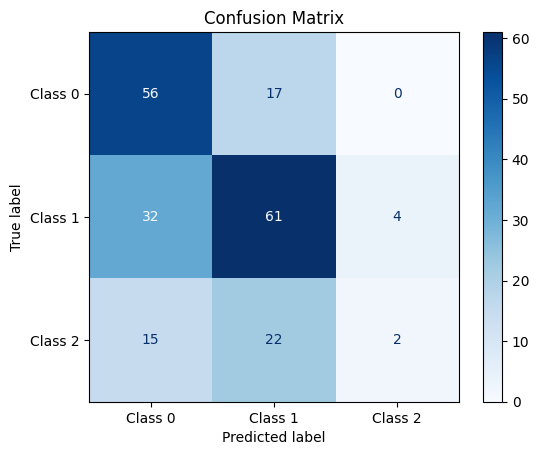

In [30]:
if __name__ == '__main__':
    data_dir = '/kaggle/input/medical'
    
    train_df = pd.read_csv('/kaggle/input/medical/data/train.csv')
    val_df = pd.read_csv('/kaggle/input/medical/data/val.csv')
    test_df = pd.read_csv('/kaggle/input/medical/data/test.csv')

    def check_path(df):
        for index, row in df.iterrows():
            mri_path = os.path.join(data_dir, row['mri_link'], 'image.nii') if pd.notna(row['mri_link']) else None
            dti_path = os.path.join(data_dir, row['dti_link'], 'image.nii') if pd.notna(row['dti_link']) else None
            
            if mri_path and not os.path.exists(mri_path):
                df.at[index, 'mri_link'] = None
            if dti_path and not os.path.exists(dti_path):
                df.at[index, 'dti_link'] = None
        return df

    train_df = check_path(train_df)
    val_df = check_path(val_df)
    test_df = check_path(test_df)

    # Cân bằng lớp cho tập train (lấy số lớp bằng với lớp có mẫu ít nhất là 241)
    def balance_classes(df):
        class_1 = df[df['diagnosis'] == 1].sample(min(241, len(df[df['diagnosis'] == 1])), random_state=42)
        class_2 = df[df['diagnosis'] == 2].sample(min(241, len(df[df['diagnosis'] == 2])), random_state=42)
        class_3 = df[df['diagnosis'] == 3]
        return pd.concat([class_1, class_2, class_3])
    
    train_df = balance_classes(train_df)
    
    scaler = StandardScaler()
    train_age = train_df['age_at_visit'].values.reshape(-1, 1)
    scaler.fit(train_age)
    
    for df in [train_df, val_df, test_df]:
        df['label'] = df['diagnosis'] - 1
        df['age_norm'] = scaler.transform(df['age_at_visit'].values.reshape(-1, 1)).flatten()
        df['gender'] = df['ptgender'] - 1

    train_dataset = MedicalDataset(train_df, data_dir, target_shape=(182, 182, 16), is_train=True)
    val_dataset = MedicalDataset(val_df, data_dir, target_shape=(182, 182, 16))
    test_dataset = MedicalDataset(test_df, data_dir, target_shape=(182, 182, 16))

    train_labels = train_df['label'].astype(int).values
    class_counts = np.bincount(train_labels)
    sample_weights = 1. / class_counts[train_labels]
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        sampler=WeightedRandomSampler(sample_weights, len(sample_weights)),
        num_workers=4,
        drop_last=True
    )
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = MADNet(num_classes=3, use_mri=False, use_dti=True).to(device)
    
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
    print(f"Class counts: {class_counts}")
    print(f"Class weights: {class_weights}")
    
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.2
    )

    print("Starting training...")
    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        epochs=70
    )

    print("Evaluating on test set...")
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                              target_names=['Class 0', 'Class 1', 'Class 2']))
    
    class_names = ['Class 0', 'Class 1', 'Class 2']
    plot_confusion_matrix(test_labels, test_preds, class_names)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

In [32]:
def print_full_results(model, train_loader, val_loader, test_loader, history, device, class_names):
    """
    In toàn bộ kết quả trên cả tập train, validation và test
    bao gồm các metrics và confusion matrix
    """
    print("\n" + "="*60)
    print("TỔNG HỢP KẾT QUẢ HUẤN LUYỆN")
    print("="*60)
    
    #epoch tốt nhất
    best_epoch = np.argmax(history['val_acc'])
    print(f"Epoch tốt nhất: {best_epoch+1}")
    print(f"Train Acc: {history['train_acc'][best_epoch]:.4f} | Val Acc: {history['val_acc'][best_epoch]:.4f}")
    print(f"Train Loss: {history['train_loss'][best_epoch]:.4f} | Val Loss: {history['val_loss'][best_epoch]:.4f}")
    
    #tập train
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TRAIN")
    print("="*60)
    train_results = evaluate_set(model, train_loader, device, "Train", class_names)
    
    #tập validation
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP VALIDATION")
    print("="*60)
    val_results = evaluate_set(model, val_loader, device, "Validation", class_names)
    
    #tập test
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TEST")
    print("="*60)
    test_results = evaluate_set(model, test_loader, device, "Test", class_names)
    
    #Tổng hợp kết quả
    print("\n" + "="*60)
    print("TỔNG HỢP CUỐI CÙNG")
    print("="*60)
    print(f"{'Dataset':<12} | {'Accuracy':<8} | {'F1 Score':<8} | {'Precision':<8} | {'Recall':<8}")
    print("-"*60)
    print(f"{'Train':<12} | {train_results['accuracy']:.4f}    | {train_results['f1']:.4f}    | {train_results['precision']:.4f}    | {train_results['recall']:.4f}")
    print(f"{'Validation':<12} | {val_results['accuracy']:.4f}    | {val_results['f1']:.4f}    | {val_results['precision']:.4f}    | {val_results['recall']:.4f}")
    print(f"{'Test':<12} | {test_results['accuracy']:.4f}    | {test_results['f1']:.4f}    | {test_results['precision']:.4f}    | {test_results['recall']:.4f}")
    
    return {
        'train': train_results,
        'val': val_results,
        'test': test_results
    }

In [33]:
def evaluate_set(model, loader, device, set_name, class_names):
    """Đánh giá mô hình trên một tập dữ liệu cụ thể với đầy đủ metric"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f'Evaluating {set_name} Set'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)
    all_probs_np = np.array(all_probs)

    accuracy = accuracy_score(all_labels_np, all_preds_np)
    f1_macro = f1_score(all_labels_np, all_preds_np, average='macro')
    f1_weighted = f1_score(all_labels_np, all_preds_np, average='weighted')
    precision = precision_score(all_labels_np, all_preds_np, average='macro')
    recall = recall_score(all_labels_np, all_preds_np, average='macro')

    try:
        auc_macro = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovo', average='macro')
    except ValueError:
        auc_macro = float('nan')

    print(f"\n{set_name} Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"AUC (Macro): {auc_macro:.4f}")

    print(f"\nClassification Report for {set_name} Set:")
    print(classification_report(all_labels_np, all_preds_np, target_names=class_names))

    print("Confusion Matrix:")
    cm = plot_confusion_matrix_only(
        all_labels_np,
        all_preds_np,
        classes=class_names,
        title=f'{set_name} Set Confusion Matrix'
    )

    return {
        'accuracy': accuracy,
        'f1': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'auc_macro': auc_macro,
        'predictions': all_preds_np,
        'labels': all_labels_np,
        'confusion_matrix': cm
    }


In [34]:
def plot_confusion_matrix_only(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()
    plt.close()

    return cm



TỔNG HỢP KẾT QUẢ HUẤN LUYỆN
Epoch tốt nhất: 26
Train Acc: 0.7111 | Val Acc: 0.5455
Train Loss: 0.6175 | Val Loss: 1.1871

ĐÁNH GIÁ TRÊN TẬP TRAIN


Evaluating Train Set: 100%|██████████| 45/45 [01:25<00:00,  1.89s/it]



Train Accuracy: 0.7278
F1-Score (Macro): 0.7288
F1-Score (Weighted): 0.7246
Recall (Macro): 0.7333
Precision (Macro): 0.7357
AUC (Macro): 0.8937

Classification Report for Train Set:
              precision    recall  f1-score   support

      Normal       0.61      0.75      0.67       237
         MCI       0.67      0.52      0.58       251
   Alzheimer       0.94      0.93      0.93       232

    accuracy                           0.73       720
   macro avg       0.74      0.73      0.73       720
weighted avg       0.73      0.73      0.72       720

Confusion Matrix:


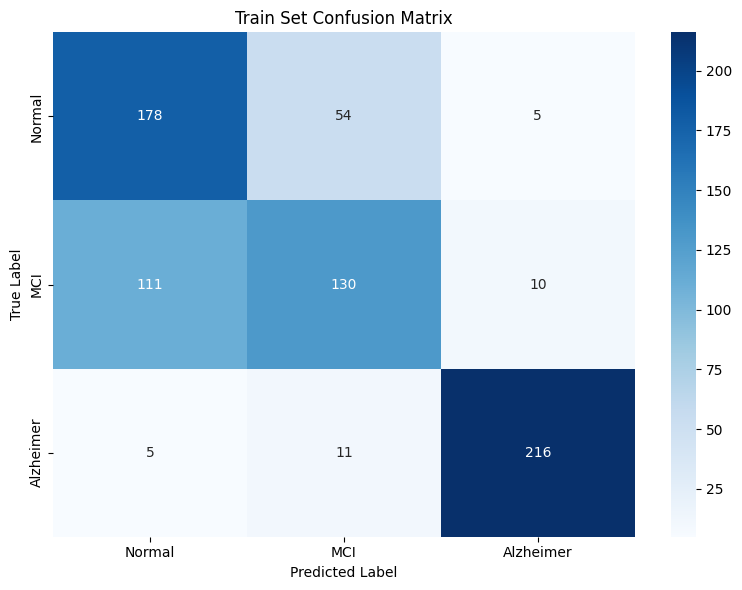


ĐÁNH GIÁ TRÊN TẬP VALIDATION


Evaluating Validation Set: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]



Validation Accuracy: 0.5101
F1-Score (Macro): 0.4340
F1-Score (Weighted): 0.4811
Recall (Macro): 0.4438
Precision (Macro): 0.5278
AUC (Macro): 0.6777

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.49      0.75      0.59        79
         MCI       0.54      0.45      0.49        83
   Alzheimer       0.56      0.14      0.22        36

    accuracy                           0.51       198
   macro avg       0.53      0.44      0.43       198
weighted avg       0.52      0.51      0.48       198

Confusion Matrix:


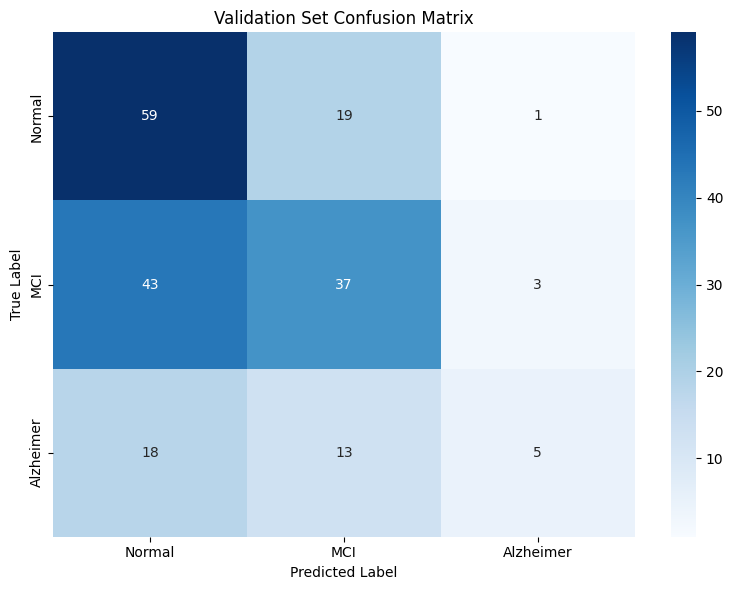


ĐÁNH GIÁ TRÊN TẬP TEST


Evaluating Test Set: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]



Test Accuracy: 0.5694
F1-Score (Macro): 0.4482
F1-Score (Weighted): 0.5263
Recall (Macro): 0.4824
Precision (Macro): 0.4957
AUC (Macro): 0.7001

Classification Report for Test Set:
              precision    recall  f1-score   support

      Normal       0.54      0.77      0.64        73
         MCI       0.61      0.63      0.62        97
   Alzheimer       0.33      0.05      0.09        39

    accuracy                           0.57       209
   macro avg       0.50      0.48      0.45       209
weighted avg       0.54      0.57      0.53       209

Confusion Matrix:


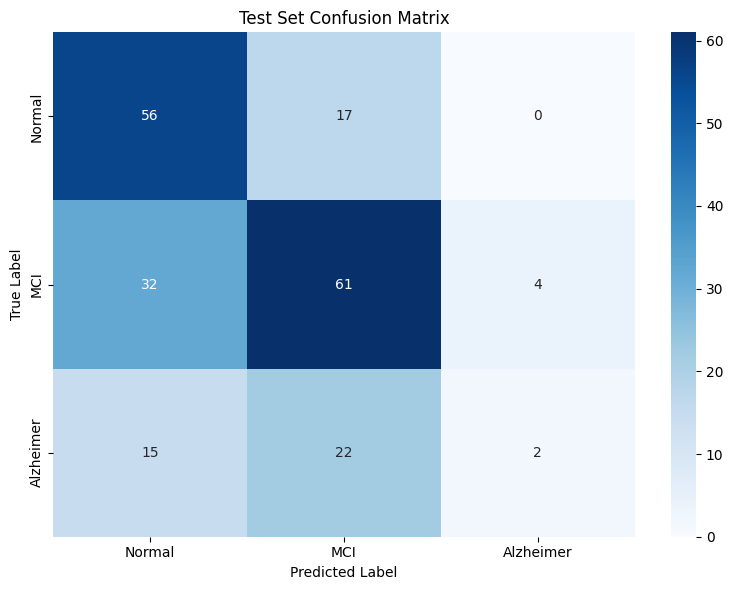


TỔNG HỢP CUỐI CÙNG
Dataset      | Accuracy | F1 Score | Precision | Recall  
------------------------------------------------------------
Train        | 0.7278    | 0.7288    | 0.7357    | 0.7333
Validation   | 0.5101    | 0.4340    | 0.5278    | 0.4438
Test         | 0.5694    | 0.4482    | 0.4957    | 0.4824


In [35]:
class_names = ['Normal', 'MCI', 'Alzheimer'] 

final_results = print_full_results(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    history=history,
    device=device,
    class_names=class_names
)